In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
df = pd.read_csv("/content/traffic.csv")
df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [6]:
df.Junction.value_counts()

1    14592
2    14592
3    14592
4     4344
Name: Junction, dtype: int64

In [7]:
df = df[df["Junction"] ==1]
df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
14587,2017-06-30 19:00:00,1,105,20170630191
14588,2017-06-30 20:00:00,1,96,20170630201
14589,2017-06-30 21:00:00,1,90,20170630211
14590,2017-06-30 22:00:00,1,84,20170630221


In [ ]:
df.isna().sum()

traffic    0
dt         0
dtype: int64

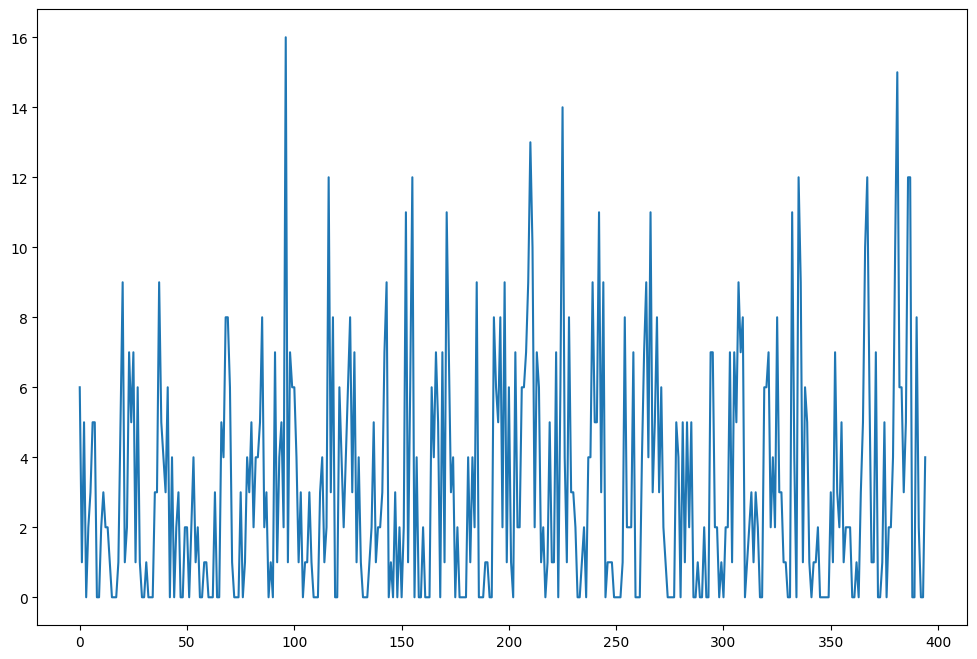

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df.traffic)

# Dickey- fully Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df["traffic"], autolag="AIC")

In [ ]:
def test_stationarity(df, ts):

  rolmean = df[ts].rolling(window=12, center= False).mean()
  rolstd =  df[ts].rolling(window=12, center = False).std()

  orig = plt.plot(df[ts], color = 'blue', label ="Original")
  mean = plt.plot(rolmean, color ='red', label ="Rolling Mean")
  std = plt.plot(rolstd, color='black', label ="Rolling Std")
  plt.legend(loc = 'best')
  plt.title("Rolling Mean and Standard Deviation for  %s" %(ts))
  plt.xticks(rotation =45)
  plt.show(block = False)
  plt.close

  print('Results:')
  dftest = adfuller(df[ts], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=["Test Statistic",'p=value','# Lasgs Used',' Number of Observations'])

  for key, value in dftest[4].items():
    dfoutput['Critical Value(%s)' %key]= value

  print(dfoutput)

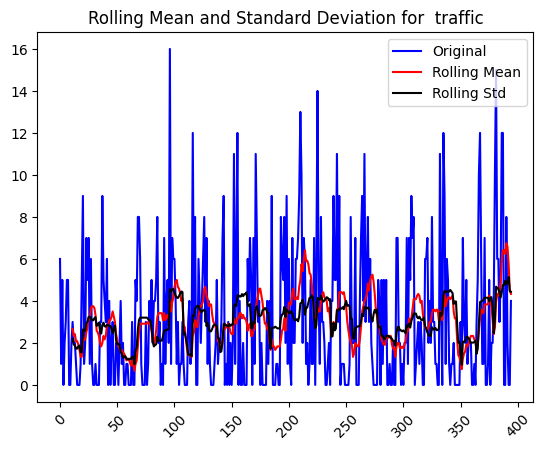

Results:
Test Statistic            -9.235436e+00
p=value                    1.635305e-15
# Lasgs Used               7.000000e+00
 Number of Observations    3.870000e+02
Critical Value(1%)        -3.447361e+00
Critical Value(5%)        -2.869037e+00
Critical Value(10%)       -2.570764e+00
dtype: float64


In [ ]:
test_stationarity(df,"traffic")

- **p-value is 4.3e-28 << 0.05. We reject H0. Therefore Traffic is stationary**

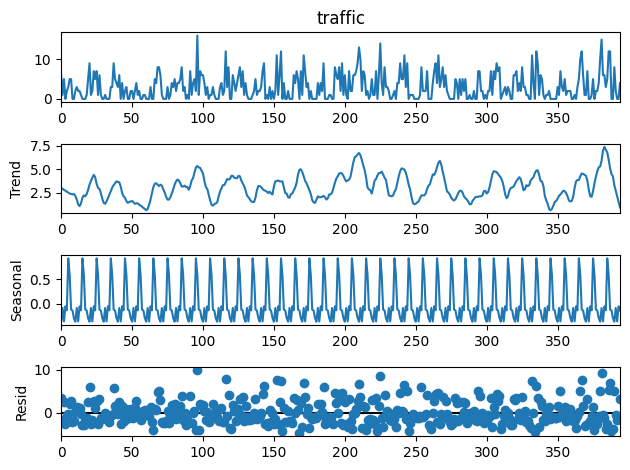

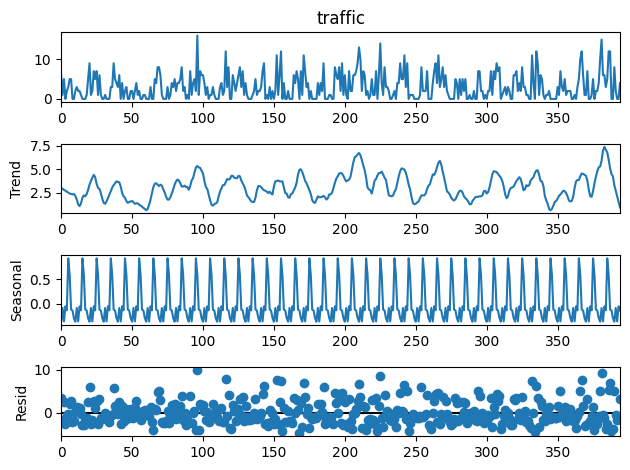

In [ ]:
decomposition = seasonal_decompose(df["traffic"], period=10, extrapolate_trend=1)
decomposition.plot()

# **PACF & ACF**

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


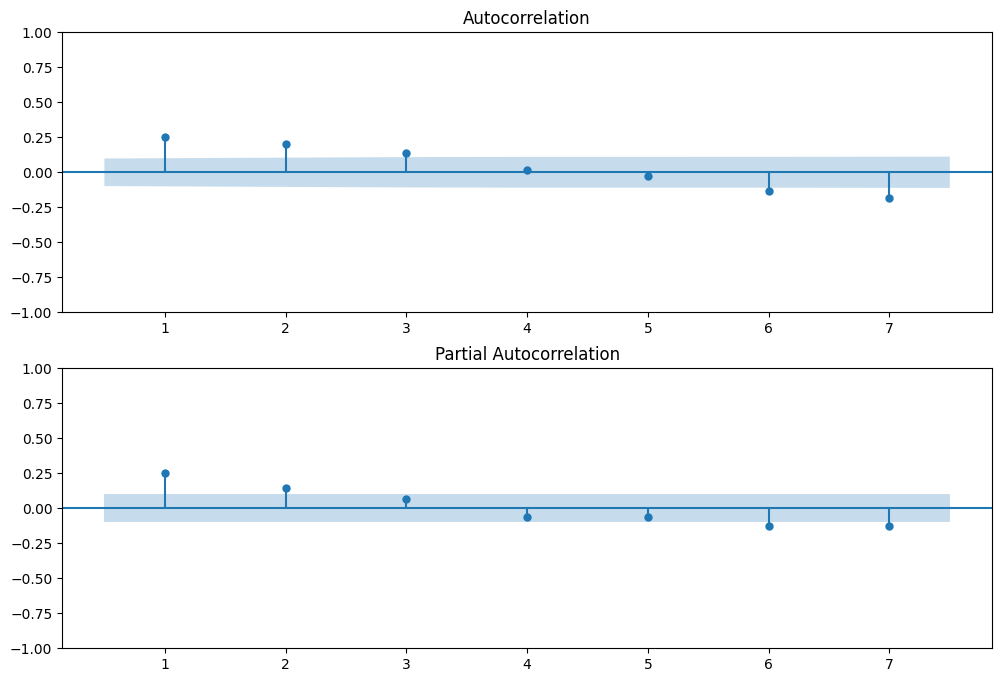

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF of df
plot_acf(df['traffic'], lags=7, zero=False, ax=ax1);

# Plot the PACF of df
plot_pacf(df['traffic'], lags=7, zero=False, ax=ax2);

## Split Data into Train and Test

In [ ]:
train, test = df.iloc[:-10,:], df.iloc[-10:,:]

In [ ]:
test

,traffic,dt
385,5,2019-08-03 13:33:05
386,12,2019-08-03 15:51:47
387,12,2019-08-03 16:04:47
388,0,2019-08-04 05:11:27
389,0,2019-08-04 08:39:11
390,8,2019-08-04 12:40:01
391,2,2019-08-04 15:25:17
392,0,2019-08-04 15:59:26
393,0,2019-08-04 18:48:56
394,4,2019-08-04 19:09:29


# **ARIMA Forecast**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def run_Arima(df,ts,p,d,q):
  model = ARIMA(df[ts], order=(p,d,q))
  results_arima = model.fit()

  len_results = len(results_arima.fittedvalues)
  ts_modified = df[ts][-len_results:]

  rss = sum((results_arima.fittedvalues-ts_modified)**2)
  rmse = np.sqrt(rss/len(df[ts]))
  print("RMSE:", rmse)

  plt.figure()
  plt.plot(df[ts])
  plt.plot(results_arima.fittedvalues, color="red")
  plt.show()

  return results_arima

RMSE: 2.9114278738323147


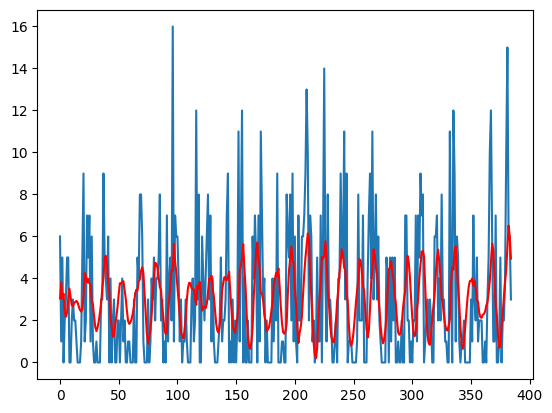

In [ ]:
model_AR = run_Arima(df=train, ts="traffic", p=3,d=0,q=3)

In [ ]:
my_forecast=model_AR.get_forecast(steps=len(test))

In [ ]:
yhat=my_forecast.predicted_mean
conf_int=my_forecast.conf_int(alpha=0.05)

In [ ]:
rss = sum((yhat-test.traffic)**2)
rmse = np.sqrt(rss/len(test))
print("RMSE:", rmse)

RMSE: 5.565548036663391


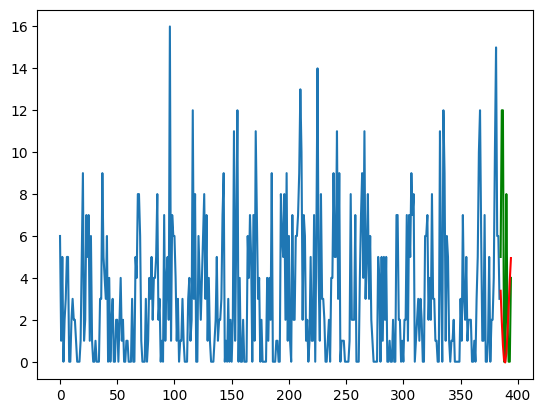

In [ ]:
plt.figure()
plt.plot(train.traffic)
plt.plot(test.traffic, color='green')
plt.plot(yhat, color='red')

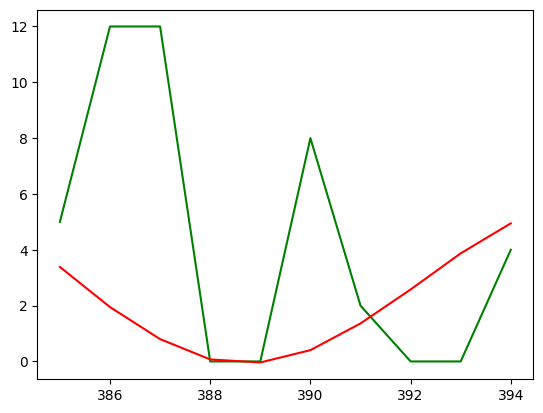

In [ ]:
plt.figure()
plt.plot(test.traffic, color='green')
plt.plot(yhat, color='red')

In [ ]:
history = [x for x in train.traffic.values]
predictions = list()

for t in range(len(test)):
 model = ARIMA(history, order=(3,0,3))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test.iloc[t,0]
 history.append(obs)
 #print('predicted=%f, expected=%f' % (yhat, obs))

predicted=3.385573, expected=5.000000
predicted=2.142947, expected=12.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.952899, expected=12.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=2.968965, expected=0.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.667594, expected=0.000000
predicted=1.466933, expected=8.000000
predicted=1.882412, expected=2.000000
predicted=2.906463, expected=0.000000
predicted=2.379699, expected=0.000000
predicted=3.178204, expected=4.000000


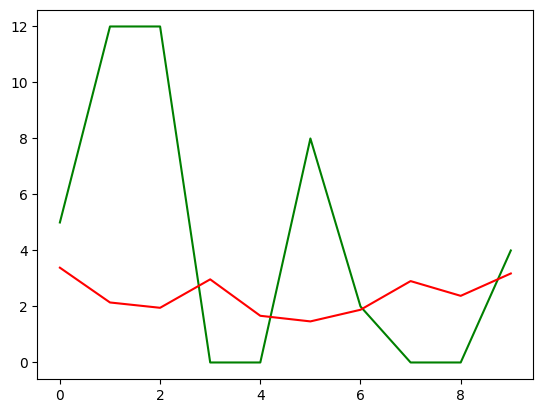

In [ ]:
plt.figure()
plt.plot(test.traffic.values, color='green')
plt.plot(predictions, color='red')

In [ ]:
rss = sum((predictions-test.traffic)**2)
rmse = np.sqrt(rss/len(test))
print("RMSE:", rmse)

RMSE: 5.19411573325702
